# 01 - Data Loading

**COVID-19 GSE171524 Single-Cell Analysis**

This notebook loads the raw count matrices from GSE171524 and creates a combined AnnData object.

## Objectives
1. Load 27 CSV.gz files (7 controls, 20 COVID samples)
2. Transpose matrices (genes as rows → cells as rows)
3. Concatenate with sample identifiers
4. Add metadata (condition, patient_id)
5. Save as `adata_raw.h5ad`

## Reference
Melms et al. (2021) "A molecular single-cell lung atlas of lethal COVID-19" Nature

In [1]:
# Import libraries
import os
import sys
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy import sparse
from pathlib import Path

warnings.filterwarnings('ignore')

# Add scripts to path
sys.path.insert(0, '../scripts')
from utils import load_csv_to_anndata, load_all_samples, save_adata

# Settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

print(f"Scanpy version: {sc.__version__}")
print(f"AnnData version: {ad.__version__}")

Scanpy version: 1.11.5
AnnData version: 0.12.7


In [2]:
# Define paths
DATA_DIR = Path('../data/raw_data')
METADATA_PATH = Path('../data/metadata/sample_metadata.csv')
OUTPUT_DIR = Path('../data/processed_data')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# List available files
raw_files = sorted(DATA_DIR.glob('*.csv.gz'))
print(f"Found {len(raw_files)} raw data files:")
for f in raw_files:
    print(f"  - {f.name}")

Found 27 raw data files:
  - GSM5226574_C51ctr_raw_counts.csv.gz
  - GSM5226575_C52ctr_raw_counts.csv.gz
  - GSM5226576_C53ctr_raw_counts.csv.gz
  - GSM5226577_C54ctr_raw_counts.csv.gz
  - GSM5226578_C55ctr_raw_counts.csv.gz
  - GSM5226579_C56ctr_raw_counts.csv.gz
  - GSM5226580_C57ctr_raw_counts.csv.gz
  - GSM5226581_L01cov_raw_counts.csv.gz
  - GSM5226582_L03cov_raw_counts.csv.gz
  - GSM5226583_L04cov_raw_counts.csv.gz
  - GSM5226584_L04covaddon_raw_counts.csv.gz
  - GSM5226585_L05cov_raw_counts.csv.gz
  - GSM5226586_L06cov_raw_counts.csv.gz
  - GSM5226587_L07cov_raw_counts.csv.gz
  - GSM5226588_L08cov_raw_counts.csv.gz
  - GSM5226589_L09cov_raw_counts.csv.gz
  - GSM5226590_L10cov_raw_counts.csv.gz
  - GSM5226591_L11cov_raw_counts.csv.gz
  - GSM5226592_L12cov_raw_counts.csv.gz
  - GSM5226593_L13cov_raw_counts.csv.gz
  - GSM5226594_L15cov_raw_counts.csv.gz
  - GSM5226595_L16cov_raw_counts.csv.gz
  - GSM5226596_L17cov_raw_counts.csv.gz
  - GSM5226597_L18cov_raw_counts.csv.gz
  - GSM522

In [3]:
# Load sample metadata
metadata = pd.read_csv(METADATA_PATH)
print(f"Sample metadata: {len(metadata)} samples")
print(f"\nConditions:")
print(metadata['condition'].value_counts())
metadata.head(10)

Sample metadata: 27 samples

Conditions:
condition
COVID      20
Control     7
Name: count, dtype: int64


,sample_id,gsm_accession,file_name,condition,patient_id,tissue,age,sex,race
0,C51,GSM5226574,GSM5226574_C51ctr_raw_counts.csv.gz,Control,C51,Lung,NaN,NaN,NaN
1,C52,GSM5226575,GSM5226575_C52ctr_raw_counts.csv.gz,Control,C52,Lung,NaN,NaN,NaN
2,C53,GSM5226576,GSM5226576_C53ctr_raw_counts.csv.gz,Control,C53,Lung,NaN,NaN,NaN
3,C54,GSM5226577,GSM5226577_C54ctr_raw_counts.csv.gz,Control,C54,Lung,NaN,NaN,NaN
4,C55,GSM5226578,GSM5226578_C55ctr_raw_counts.csv.gz,Control,C55,Lung,NaN,NaN,NaN
5,C56,GSM5226579,GSM5226579_C56ctr_raw_counts.csv.gz,Control,C56,Lung,NaN,NaN,NaN
6,C57,GSM5226580,GSM5226580_C57ctr_raw_counts.csv.gz,Control,C57,Lung,NaN,NaN,NaN
7,L01,GSM5226581,GSM5226581_L01cov_raw_counts.csv.gz,COVID,L01,Lung,NaN,NaN,NaN
8,L03,GSM5226582,GSM5226582_L03cov_raw_counts.csv.gz,COVID,L03,Lung,NaN,NaN,NaN
9,L04,GSM5226583,GSM5226583_L04cov_raw_counts.csv.gz,COVID,L04,Lung,NaN,NaN,NaN


## Load Sample Data

Each CSV file has:
- Rows: Genes (~34,546)
- Columns: Cells (barcodes)

We'll transpose to have cells as rows (AnnData convention).

In [4]:
# Peek at one file to understand the structure
sample_file = raw_files[0]
print(f"Examining: {sample_file.name}")

# Read first few rows and columns
df_peek = pd.read_csv(sample_file, index_col=0, nrows=5)
print(f"\nShape (genes x cells): {df_peek.shape}")
print(f"\nFirst 5 genes:")
print(df_peek.index.tolist())
print(f"\nFirst 5 cell barcodes:")
print(df_peek.columns[:5].tolist())

Examining: GSM5226574_C51ctr_raw_counts.csv.gz

Shape (genes x cells): (5, 6099)

First 5 genes:
['AL627309.1', 'AL627309.5', 'AL627309.4', 'AL669831.2', 'LINC01409']

First 5 cell barcodes:
['TAGGTACCATGGCCAC-1_1', 'ATTCACTGTAACAGGC-1_1', 'TAACTTCCAACCACGC-1_1', 'TTGGGTACACGACAAG-1_1', 'AGGCCACAGAGTCACG-1_1']


In [5]:
# Load all samples and concatenate
# This may take several minutes depending on file sizes

print("Loading all samples...\n")

adatas = []
for _, row in metadata.iterrows():
    file_path = DATA_DIR / row['file_name']
    sample_id = row['sample_id']
    
    print(f"Loading {sample_id}...", end=' ')
    
    # Load and transpose
    adata = load_csv_to_anndata(str(file_path), sample_id)
    
    # Add metadata
    adata.obs['condition'] = row['condition']
    adata.obs['patient_id'] = row['patient_id']
    adata.obs['gsm_accession'] = row['gsm_accession']
    
    print(f"{adata.n_obs:,} cells, {adata.n_vars:,} genes")
    adatas.append(adata)

print(f"\nLoaded {len(adatas)} samples")

Loading all samples...

Loading C51... 6,099 cells, 34,546 genes
Loading C52... 4,513 cells, 34,546 genes
Loading C53... 7,120 cells, 34,546 genes
Loading C54... 4,382 cells, 34,546 genes
Loading C55... 5,685 cells, 34,546 genes
Loading C56... 4,090 cells, 34,546 genes
Loading C57... 4,789 cells, 34,546 genes
Loading L01... 3,060 cells, 34,546 genes
Loading L03... 5,060 cells, 34,546 genes
Loading L04... 3,630 cells, 34,546 genes
Loading L04addon... 4,574 cells, 34,546 genes
Loading L05... 3,052 cells, 34,546 genes
Loading L06... 7,582 cells, 34,546 genes
Loading L07... 5,074 cells, 34,546 genes
Loading L08... 4,149 cells, 34,546 genes
Loading L09... 3,605 cells, 34,546 genes
Loading L10... 1,550 cells, 34,546 genes
Loading L11... 3,296 cells, 34,546 genes
Loading L12... 3,876 cells, 34,546 genes
Loading L13... 4,862 cells, 34,546 genes
Loading L15... 4,056 cells, 34,546 genes
Loading L16... 1,822 cells, 34,546 genes
Loading L17... 4,651 cells, 34,546 genes
Loading L18... 2,816 cells, 

In [6]:
# Concatenate all samples
print("Concatenating samples...")

adata = ad.concat(
    adatas,
    join='outer',
    merge='same',
    uns_merge='same',
    index_unique='_'
)

# Make var_names unique
adata.var_names_make_unique()

print(f"\nCombined AnnData:")
print(f"  Total cells: {adata.n_obs:,}")
print(f"  Total genes: {adata.n_vars:,}")
print(f"  Samples: {adata.obs['sample_id'].nunique()}")

Concatenating samples...

Combined AnnData:
  Total cells: 116,314
  Total genes: 34,546
  Samples: 27


In [7]:
# Verify cell counts per sample
cell_counts = adata.obs.groupby(['sample_id', 'condition']).size().reset_index(name='n_cells')
cell_counts = cell_counts.sort_values('condition')

print("Cells per sample:")
print(cell_counts.to_string(index=False))

print(f"\nTotal by condition:")
print(adata.obs['condition'].value_counts())

Cells per sample:
sample_id condition  n_cells
      L07     COVID     5074
      L19     COVID     2509
      L18     COVID     2816
      L17     COVID     4651
      L16     COVID     1822
      L15     COVID     4056
      L13     COVID     4862
      L12     COVID     3876
      L11     COVID     3296
      L10     COVID     1550
      L09     COVID     3605
      L08     COVID     4149
      L21     COVID     3425
      L22     COVID     6987
      L05     COVID     3052
 L04addon     COVID     4574
      L04     COVID     3630
      L03     COVID     5060
      L01     COVID     3060
      L06     COVID     7582
      C57   Control     4789
      C56   Control     4090
      C55   Control     5685
      C54   Control     4382
      C53   Control     7120
      C52   Control     4513
      C51   Control     6099

Total by condition:
condition
COVID      79636
Control    36678
Name: count, dtype: int64


In [8]:
# Check data structure
print("AnnData structure:")
print(adata)

print("\nObservations (cells):")
print(adata.obs.head())

print("\nVariables (genes):")
print(adata.var.head())

print("\nData matrix:")
print(f"  Type: {type(adata.X)}")
print(f"  Shape: {adata.X.shape}")
print(f"  Dtype: {adata.X.dtype}")

AnnData structure:
AnnData object with n_obs × n_vars = 116314 × 34546
    obs: 'sample_id', 'condition', 'patient_id', 'gsm_accession'

Observations (cells):
                       sample_id condition patient_id gsm_accession
TAGGTACCATGGCCAC-1_1_0       C51   Control        C51    GSM5226574
ATTCACTGTAACAGGC-1_1_0       C51   Control        C51    GSM5226574
TAACTTCCAACCACGC-1_1_0       C51   Control        C51    GSM5226574
TTGGGTACACGACAAG-1_1_0       C51   Control        C51    GSM5226574
AGGCCACAGAGTCACG-1_1_0       C51   Control        C51    GSM5226574

Variables (genes):
Empty DataFrame
Columns: []
Index: [AL627309.1, AL627309.5, AL627309.4, AL669831.2, LINC01409]

Data matrix:
  Type: <class 'scipy.sparse._csr.csr_matrix'>
  Shape: (116314, 34546)
  Dtype: float32


In [9]:
# Basic data checks
print("Data quality checks:")

# Check for all-zero cells/genes
if sparse.issparse(adata.X):
    cells_with_counts = np.array((adata.X.sum(axis=1) > 0).flatten())[0]
    genes_with_counts = np.array((adata.X.sum(axis=0) > 0).flatten())[0]
else:
    cells_with_counts = adata.X.sum(axis=1) > 0
    genes_with_counts = adata.X.sum(axis=0) > 0

print(f"  Cells with counts: {cells_with_counts.sum():,} / {adata.n_obs:,}")
print(f"  Genes with counts: {genes_with_counts.sum():,} / {adata.n_vars:,}")

# Check for negative values
if sparse.issparse(adata.X):
    min_val = adata.X.min()
else:
    min_val = np.min(adata.X)
print(f"  Min value: {min_val} (should be >= 0)")

Data quality checks:
  Cells with counts: 116,314 / 116,314
  Genes with counts: 34,367 / 34,546
  Min value: 0.0 (should be >= 0)


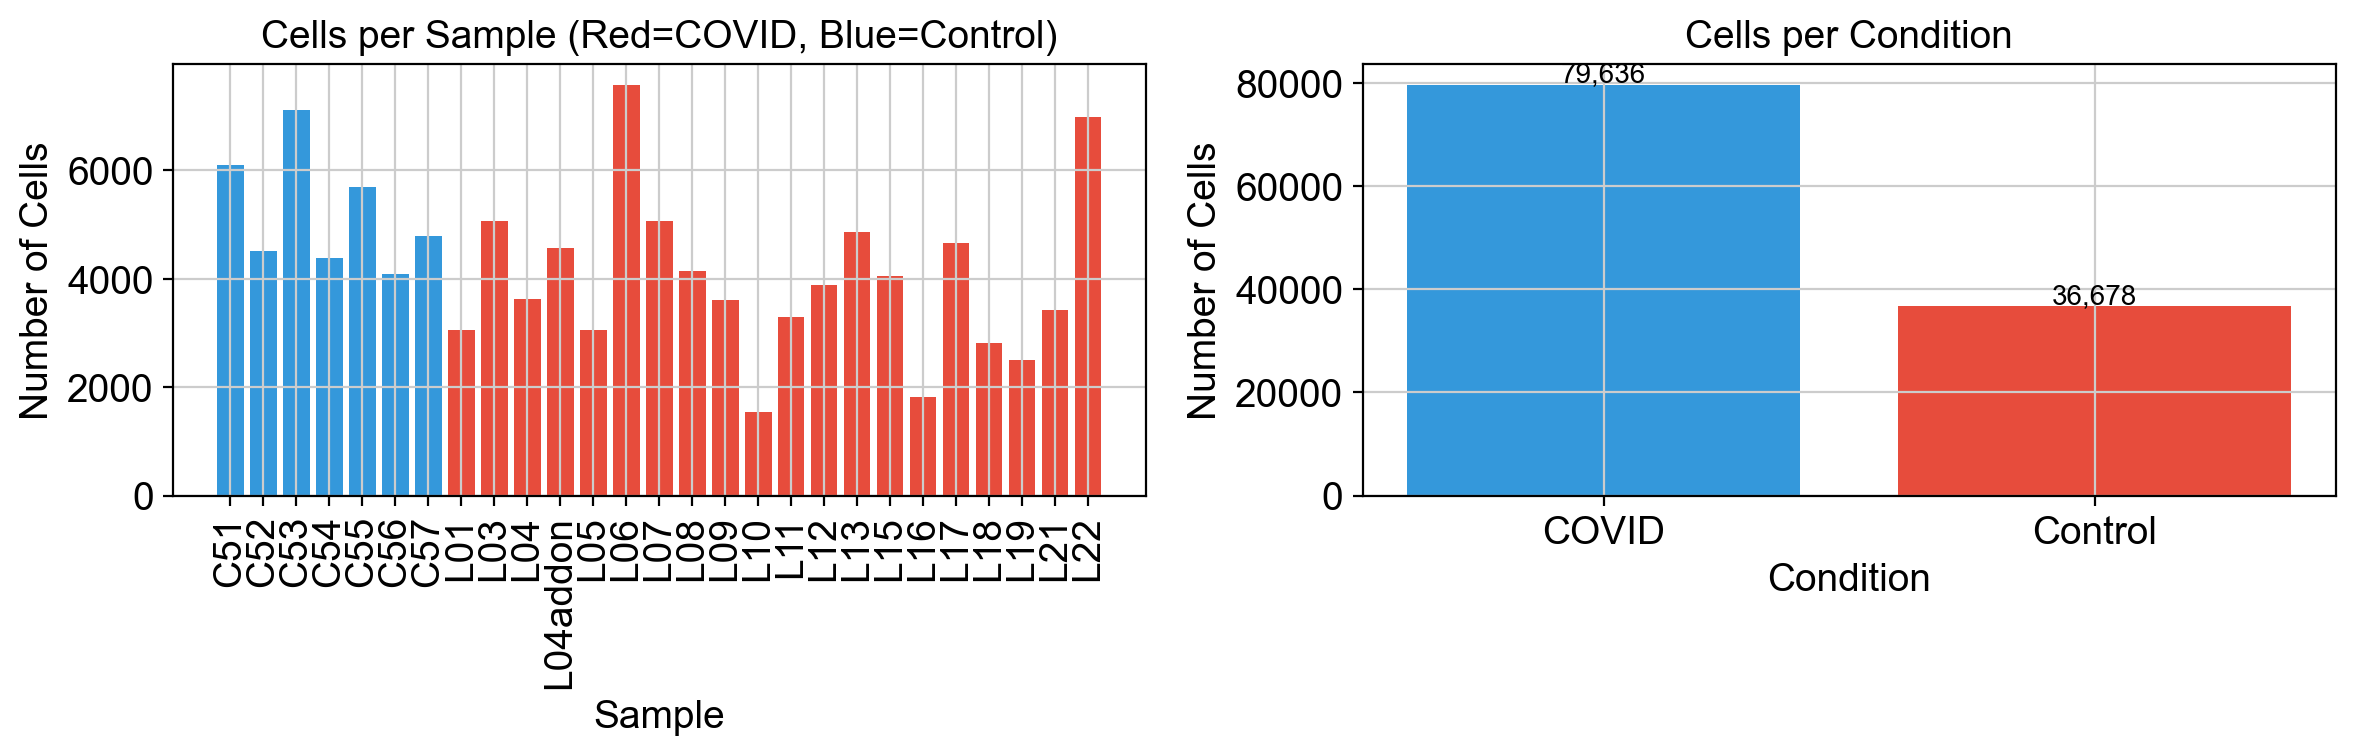

In [10]:
# Visualize cell count distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cells per sample
sample_counts = adata.obs['sample_id'].value_counts().sort_index()
colors = ['#E74C3C' if 'L' in s else '#3498DB' for s in sample_counts.index]
axes[0].bar(range(len(sample_counts)), sample_counts.values, color=colors)
axes[0].set_xticks(range(len(sample_counts)))
axes[0].set_xticklabels(sample_counts.index, rotation=90)
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Cells per Sample (Red=COVID, Blue=Control)')

# Cells per condition
cond_counts = adata.obs['condition'].value_counts()
axes[1].bar(cond_counts.index, cond_counts.values, color=['#3498DB', '#E74C3C'])
axes[1].set_xlabel('Condition')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Cells per Condition')

for i, (cond, count) in enumerate(cond_counts.items()):
    axes[1].text(i, count + 500, f'{count:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# Save raw AnnData
output_path = OUTPUT_DIR / 'adata_raw.h5ad'

print(f"Saving to: {output_path}")
adata.write_h5ad(output_path, compression='gzip')

print(f"\nFile saved: {output_path}")
print(f"File size: {output_path.stat().st_size / 1e9:.2f} GB")

Saving to: ../data/processed_data/adata_raw.h5ad

File saved: ../data/processed_data/adata_raw.h5ad
File size: 0.26 GB


## Summary

### Data Loaded
- **Total cells**: ~116,000 nuclei
- **Total genes**: ~34,546
- **Samples**: 27 (7 Control, 20 COVID)

### Output
- `data/processed_data/adata_raw.h5ad` - Raw concatenated AnnData

### Next Steps
→ **02_quality_control.ipynb**: Filter low-quality cells and doublets

In [ ]:
# Session info
print("\n=== Session Info ===")
print(f"Scanpy: {sc.__version__}")
print(f"AnnData: {ad.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")